In [3]:
from tensorflow.keras import layers
import tensorflow_addons as tfa
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

tf.random.set_seed(42)
np.random.seed(42)

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [5]:
x_train.shape

(60000, 28, 28, 1)

In [6]:
x_test.shape

(10000, 28, 28, 1)

In [7]:
BATCH_SIZE = 64
EPOCHS = 10
INIT_LR = 1e-4
MAX_LR = 1e-2

In [8]:
def get_training_model():
    model = tf.keras.Sequential(
        [
            layers.InputLayer((28, 28, 1)),
            layers.experimental.preprocessing.Rescaling(scale=1./255),
            layers.Conv2D(16, (5, 5), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(32, (5, 5), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.SpatialDropout2D(0.2),
            layers.GlobalAvgPool2D(),
            layers.Dense(128, activation="relu"),
            layers.Dense(10, activation="softmax"),
        ]
    )
    return model

def train_model(model, optimizer):
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                       metrics=["accuracy"])
    history = model.fit(x_train,
        y_train,
        batch_size=BATCH_SIZE,
        validation_data=(x_test, y_test),
        epochs=EPOCHS)
    return history

In [9]:
initial_model = get_training_model()
initial_model.save("initial_model")

INFO:tensorflow:Assets written to: initial_model\assets


## Train model without CLR

In [10]:
standard_model = tf.keras.models.load_model("initial_model")
no_clr_history = train_model(standard_model, optimizer="sgd")

Epoch 1/10
938/938 [==============================] - 26s 27ms/step - loss: 2.2091 - accuracy: 0.2182 - val_loss: 1.7597 - val_accuracy: 0.4125
Epoch 2/10
938/938 [==============================] - 24s 26ms/step - loss: 1.2961 - accuracy: 0.5130 - val_loss: 0.9589 - val_accuracy: 0.6482
Epoch 3/10
938/938 [==============================] - 24s 26ms/step - loss: 1.0104 - accuracy: 0.6183 - val_loss: 0.9140 - val_accuracy: 0.6589
Epoch 4/10
938/938 [==============================] - 25s 26ms/step - loss: 0.9277 - accuracy: 0.6567 - val_loss: 0.8479 - val_accuracy: 0.7024
Epoch 5/10
938/938 [==============================] - 25s 26ms/step - loss: 0.8857 - accuracy: 0.6717 - val_loss: 0.8404 - val_accuracy: 0.6665
Epoch 6/10
938/938 [==============================] - 24s 26ms/step - loss: 0.8482 - accuracy: 0.6851 - val_loss: 0.7970 - val_accuracy: 0.6828
Epoch 7/10
938/938 [==============================] - 24s 26ms/step - loss: 0.8219 - accuracy: 0.6940 - val_loss: 0.7608 - val_accuracy:

## Define CLR schdule

Here, you specify the lower and upper bounds of the learning rate and the schedule will oscillate in between that range ([1e-4, 1e-2] in this case). scale_fn is used to define the function that would scale up and scale down the learning rate within a given cycle. step_size defines the duration of a single cycle. A step_size of 2 means you need a total of 4 iterations to complete one cycle. The recommended value for step_size is as follows:

factor * steps_per_epoch where factor lies within the [2, 8] range

In [11]:
steps_per_epoch = len(x_train) // BATCH_SIZE
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch
)
optimizer = tf.keras.optimizers.SGD(clr)

## How CLR schdular look like

In [12]:
EPOCHS,steps_per_epoch

(10, 937)

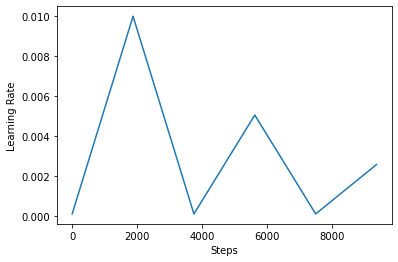

In [13]:
step = np.arange(0, EPOCHS * steps_per_epoch)
lr = clr(step)
plt.plot(step, lr)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.show()

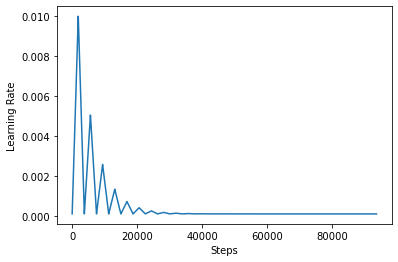

In [14]:
step = np.arange(0, 100 * steps_per_epoch)
lr = clr(step)
plt.plot(step, lr)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.show()

In [15]:
clr_model = tf.keras.models.load_model("initial_model")
clr_history = train_model(clr_model, optimizer=optimizer)

Epoch 1/10
938/938 [==============================] - 25s 26ms/step - loss: 2.3005 - accuracy: 0.1165 - val_loss: 2.2852 - val_accuracy: 0.2374
Epoch 2/10
938/938 [==============================] - 24s 26ms/step - loss: 2.1930 - accuracy: 0.2397 - val_loss: 1.7386 - val_accuracy: 0.4512
Epoch 3/10
938/938 [==============================] - 24s 26ms/step - loss: 1.3132 - accuracy: 0.5051 - val_loss: 1.0111 - val_accuracy: 0.6493
Epoch 4/10
938/938 [==============================] - 24s 26ms/step - loss: 1.0748 - accuracy: 0.5935 - val_loss: 0.9492 - val_accuracy: 0.6624
Epoch 5/10
938/938 [==============================] - 25s 27ms/step - loss: 1.0530 - accuracy: 0.6029 - val_loss: 0.9440 - val_accuracy: 0.6522
Epoch 6/10
938/938 [==============================] - 24s 26ms/step - loss: 1.0199 - accuracy: 0.6174 - val_loss: 0.9097 - val_accuracy: 0.6622
Epoch 7/10
938/938 [==============================] - 24s 26ms/step - loss: 0.9779 - accuracy: 0.6345 - val_loss: 0.8783 - val_accuracy:

<ipython-input-16-a6bb201b18c7>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


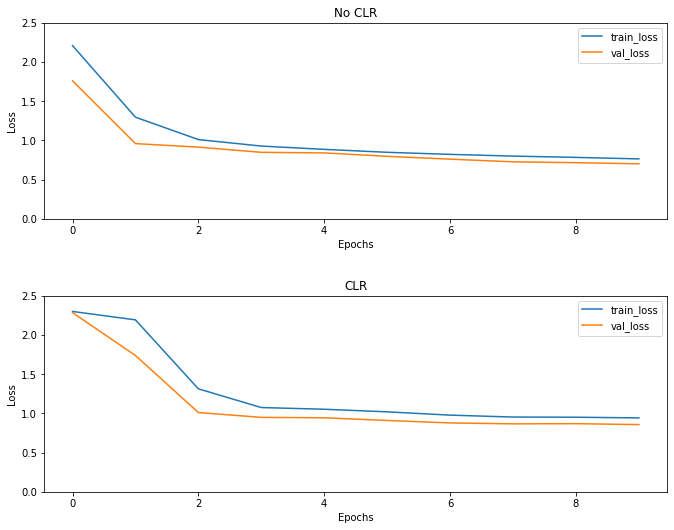

In [16]:
(fig, ax) = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(no_clr_history.history["loss"], label="train_loss")
ax[0].plot(no_clr_history.history["val_loss"], label="val_loss")
ax[0].set_title("No CLR")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_ylim([0, 2.5])
ax[0].legend()

ax[1].plot(clr_history.history["loss"], label="train_loss")
ax[1].plot(clr_history.history["val_loss"], label="val_loss")
ax[1].set_title("CLR")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].set_ylim([0, 2.5])
ax[1].legend()

fig.tight_layout(pad=3.0)
fig.show()

# Even though for this toy example, you did not see the effects of CLR much but be noted that it is one of the main ingredients behind Super Convergence and can have a really good impact when training in large-scale settings